# Pipeline

## Functions

In [1]:
from week4_functions import *

In [22]:

def find_best_score_threshold(
    rates,
    gt_corresps,
    metric: str = "f1",     # "f1" | "accuracy" | "youden"
    plot: bool = False,
    title_xlabel: str = "Query Index",
    title_ylabel: str = "Normalized Score",
    ax=None,
    plot_threshold_line: bool = True,
):
    """
    Determine the optimal threshold on match 'rates' to classify:
      known (label=1) vs unknown (label=0, gt == -1).

    Parameters
    ----------
    rates : list[list[float]]
        Per-(sub)query normalized scores (same structure as returned by compute_matches).
    gt_corresps : list[list[int]]
        Per-(sub)query ground-truth indices; -1 denotes unknown (same structure as your GT).
    metric : str
        Criterion to optimize: "f1" (default), "accuracy", or "youden" (TPR - FPR).
    plot : bool
        If True, draws a scatter of scores and a horizontal line at the best threshold.
    ax : matplotlib Axes
        Optional axes to plot on.

    Returns
    -------
    best_threshold : float
    decision_side : str        # ">=" or "<=" meaning 'predict known if score SIDE threshold'
    metrics : dict             # F1, precision, recall, accuracy at best threshold
    y_pred : np.ndarray        # predictions (1 known / 0 unknown) for the *flattened* scores
    """

    # Flatten scores and build binary labels: 1=known, 0=unknown
    scores = np.array([s for sub in rates for s in sub], dtype=float)
    y_true = np.array([0 if x == -1 else 1 for sub in gt_corresps for x in sub], dtype=int)

    if scores.size == 0:
        raise ValueError("Empty 'rates' provided.")

    # Decide direction automatically: do knowns tend to have higher scores?
    mean_known = scores[y_true == 1].mean() if np.any(y_true == 1) else -np.inf
    mean_unk   = scores[y_true == 0].mean() if np.any(y_true == 0) else  np.inf
    predict_known_if_higher = (mean_known >= mean_unk)
    side_symbol = ">=" if predict_known_if_higher else "<="

    def preds_from_threshold(th):
        if predict_known_if_higher:
            return (scores >= th).astype(int)
        else:
            return (scores <= th).astype(int)

    # Candidate thresholds: midpoints between sorted unique scores + two safe extremes
    uniq = np.unique(scores)
    if uniq.size == 1:
        # Degenerate case: all scores equal -> any threshold yields same preds
        th_edges = np.array([uniq[0]])
    else:
        th_edges = np.concatenate([[uniq.min() - 1e-12],
                                   (uniq[:-1] + uniq[1:]) / 2.0,
                                   [uniq.max() + 1e-12]])

    def youden(y_true, y_hat):
        # TPR - FPR
        tp = np.sum((y_true == 1) & (y_hat == 1))
        fn = np.sum((y_true == 1) & (y_hat == 0))
        fp = np.sum((y_true == 0) & (y_hat == 1))
        tn = np.sum((y_true == 0) & (y_hat == 0))
        tpr = tp / (tp + fn) if (tp + fn) else 0.0
        fpr = fp / (fp + tn) if (fp + tn) else 0.0
        return tpr - fpr

    best_key = -np.inf
    best = {"threshold": None, "f1": None, "precision": None, "recall": None, "accuracy": None}
    best_pred = None

    for th in th_edges:
        y_hat = preds_from_threshold(th)
        f1  = f1_score(y_true, y_hat, zero_division=0)
        pre = precision_score(y_true, y_hat, zero_division=0)
        rec = recall_score(y_true, y_hat, zero_division=0)
        acc = (y_true == y_hat).mean()

        key = {"f1": f1, "accuracy": acc, "youden": youden(y_true, y_hat)}[metric]
        if key > best_key:
            best_key = key
            best = {"threshold": th, "f1": f1, "precision": pre, "recall": rec, "accuracy": acc}
            best_pred = y_hat

    # Optional plot
    if plot:
        import matplotlib.pyplot as plt
        if ax is None:
            fig, ax = plt.subplots(figsize=(6,4))
        colors = ['red' if y == 0 else 'green' for y in y_true]
        ax.scatter(range(len(scores)), scores, c=colors, alpha=0.6)
        if plot_threshold_line:
            ax.axhline(best["threshold"], linestyle="--")
            ax.set_title(f"Scores with Best Threshold ({metric.upper()})")
        else:
            ax.set_title("Scores")
        ax.set_xlabel(title_xlabel)
        ax.set_ylabel(title_ylabel)

    return float(best["threshold"]), side_symbol, best, best_pred



## SIFT

✅ Loading DB descriptors from results/descriptors_db_sift.pkl
📥 Loading query images...
📥 Loading ground-truth correspondences...
→ 30 GT entries loaded
🧠 Computing SIFT for queries...
✅ Loading query descriptors from results/query_descriptors_SIFT.pkl
🏆 Evaluating retrieval performance...


Processing queries: 100%|██████████| 30/30 [04:55<00:00,  9.84s/it]


Min score for correct matches: 0.1073345259391771
Max score for incorrect matches: 0.2664446294754371
Best threshold: score >= 0.091547 → predict KNOWN
F1=0.933  Precision=0.903  Recall=0.966  Acc=0.897
✅ mAP@1 = 0.6667
✅ mAP@5 = 0.6667


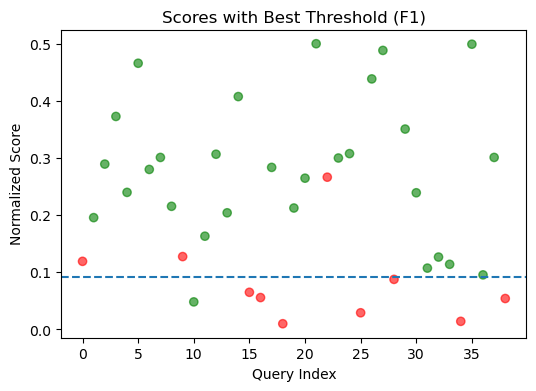

In [40]:
# =========================
# Main (example wiring)
# =========================

# --- Config (adjust as needed) ---
DB_FOLDER      = "../Data/BBDD/"
QUERY_FOLDER   = "../Data/Week4/qsd1_w4/"
GT_PATH        = "../Data/Week4/qsd1_w4/gt_corresps.pkl"
DESC_DB_PATH   = "results/descriptors_db_sift.pkl"

DESCRIPTOR         = "SIFT"

# SIFT & matching parameters
NFEATURES          = 1200
ROOTSIFT           = True
LOWE_RATIO         = 0.76       # Lowe ratio for 2-NN filtering
RATE_THRESHOLD     = 0.28      ######
MIN_SIZE_RATIO     = 0.20       # split validation
CROP_MIN_RATIO     = 0.20       # single fallback if either crop too small
BG_CROP_MIN_RATIO  = 0.10       # background crop too small -> use original
SHOW_VIS           = False
INFO_PRINT         = False
SAVE_QUERY_DESC    = True        # whether to save/load query descriptors to/from pickle (keep true if no changes in the descriptor parameters)


os.makedirs("results", exist_ok=True)

# 1) Matcher
matcher = create_matcher(DESCRIPTOR)

# 2) DB descriptors
db_descs, db_names = build_or_load_db_descriptors(
    DB_FOLDER,
    DESC_DB_PATH,
    nfeatures=NFEATURES,
    rootsift=ROOTSIFT,
    use_cache=True,
    progress=True,
)

# 3) Queries + GT
print("📥 Loading query images...")
q_names, q_imgs = load_images_from_folder(QUERY_FOLDER)
print("📥 Loading ground-truth correspondences...")
with open(GT_PATH, "rb") as f:
    gt_corresps = pickle.load(f)
print(f"→ {len(gt_corresps)} GT entries loaded")

# 3) Query descriptors
print("🧠 Computing SIFT for queries...")
desc_query_sift = compute_query_descriptors(
    q_imgs,
    q_names,
    preprocess_image=preprocess_image,
    segment_multiple_paintings=segment_multiple_paintings,
    validate_split_fn=lambda is_split, imgs: validate_split(is_split, imgs, min_size_ratio=MIN_SIZE_RATIO),
    background_remover=background_remover,
    nfeatures=NFEATURES,
    rootsift=ROOTSIFT,
    crop_min_ratio_single=CROP_MIN_RATIO,
    bg_crop_min_ratio=BG_CROP_MIN_RATIO,
    show_img=SHOW_VIS,
    info=INFO_PRINT,
    save=SAVE_QUERY_DESC,
)

# 4) Ranking + mAP
print("🏆 Evaluating retrieval performance...")
predicted_sift, predicted_norm_scores_sift, predicted_scores_sift, predicted_num_features_sift = compute_matches(
    desc_query_sift,
    db_descs,
    gt_corresps,
    matcher=matcher,
    ratio=LOWE_RATIO,
    rate_threshold=RATE_THRESHOLD,
    # descriptor_type=DESCRIPTOR,
)

# Pick the best threshold from the produced rates + GT
best_th_sift, side_sift, metrics_sift, y_pred_sift = find_best_score_threshold(
    rates=predicted_norm_scores_sift,
    gt_corresps=gt_corresps,
    metric="f1",     # or "accuracy" / "youden"
    plot=True        # set False if you don’t want the visualization
)

print(f"Best threshold: score {side_sift} {best_th_sift:.6f} → predict KNOWN")
print(f"F1={metrics_sift['f1']:.3f}  Precision={metrics_sift['precision']:.3f}  "
      f"Recall={metrics_sift['recall']:.3f}  Acc={metrics_sift['accuracy']:.3f}")

map5_sift = mapk(gt_corresps, predicted_sift, k=5, skip_unknown=False)
map1_sift = mapk(gt_corresps, predicted_sift, k=1, skip_unknown=False)

print(f"✅ mAP@1 = {map1_sift:.4f}")
print(f"✅ mAP@5 = {map5_sift:.4f}")


Best threshold: score >= 9.000000 → predict KNOWN
F1=0.853  Precision=0.744  Recall=1.000  Acc=0.744


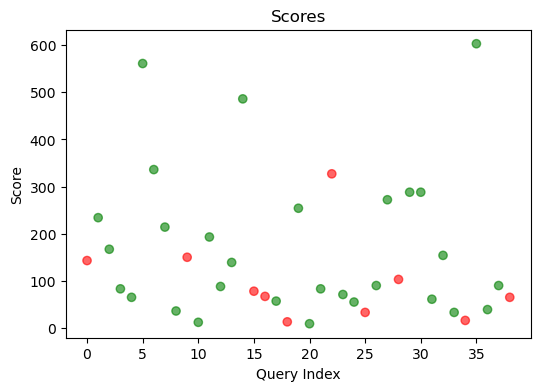

In [23]:
# Pick the best threshold from the produced rates + GT
best_th_sift_old, side_sift_old, metrics_sift_old, y_pred_sift_old = find_best_score_threshold(
    rates=predicted_scores_sift,
    gt_corresps=gt_corresps,
    metric="f1",     # or "accuracy" / "youden"
    plot=True,        # set False if you don’t want the visualization
    title_ylabel="Score",
    plot_threshold_line=False,
)

print(f"Best threshold: score {side_sift_old} {best_th_sift_old:.6f} → predict KNOWN")
print(f"F1={metrics_sift_old['f1']:.3f}  Precision={metrics_sift_old['precision']:.3f}  "
      f"Recall={metrics_sift_old['recall']:.3f}  Acc={metrics_sift_old['accuracy']:.3f}")

Best threshold: score >= 9.000000 → predict KNOWN
F1=0.853  Precision=0.744  Recall=1.000  Acc=0.744


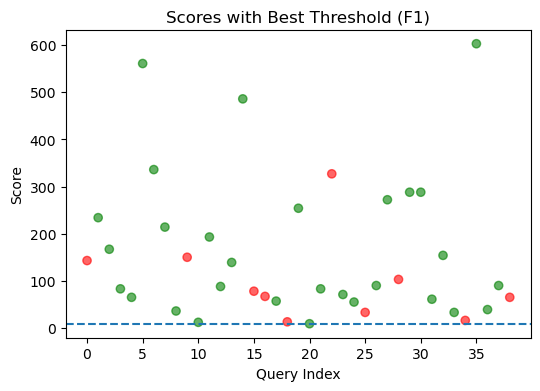

In [14]:
# Pick the best threshold from the produced rates + GT
best_th_sift_old, side_sift_old, metrics_sift_old, y_pred_sift_old = find_best_score_threshold(
    rates=predicted_scores_sift,
    gt_corresps=gt_corresps,
    metric="f1",     # or "accuracy" / "youden"
    plot=True,        # set False if you don’t want the visualization
    title_ylabel="Score",
)

print(f"Best threshold: score {side_sift_old} {best_th_sift_old:.6f} → predict KNOWN")
print(f"F1={metrics_sift_old['f1']:.3f}  Precision={metrics_sift_old['precision']:.3f}  "
      f"Recall={metrics_sift_old['recall']:.3f}  Acc={metrics_sift_old['accuracy']:.3f}")

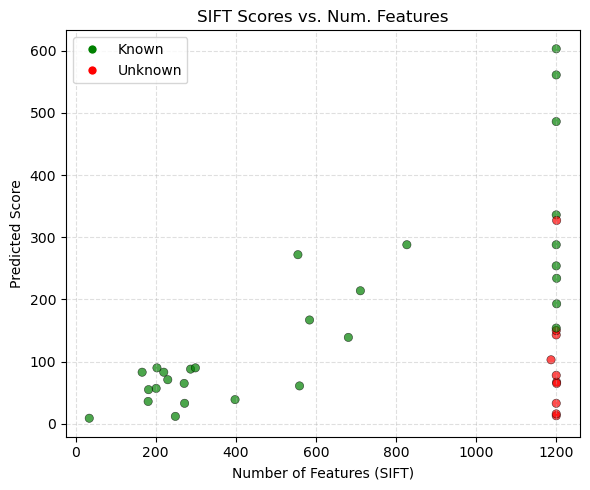

In [10]:
plot_score_vs_features(predicted_scores_sift, predicted_num_features_sift, gt_corresps)

In [41]:
RATE_THRESHOLD = 0.089448
DESCRIPTOR = "SIFT"
f1 = evaluate_unknown_threshold(gt_corresps, predicted_sift,
                                threshold_name=f"rate{RATE_THRESHOLD:.3f}", 
                                descriptor=DESCRIPTOR)


Threshold rate0.089 → Precision=1.000, Recall=0.552, F1=0.711


Rate threshold = 0.05 gives:
✅ mAP@1 = 0.7436
✅ mAP@5 = 0.7500
Threshold rate0.050 → Precision=0.806, Recall=1.000, F1=0.892

Rate threshold = 0.075 gives:
✅ mAP@1 = 0.8205
✅ mAP@5 = 0.8269
Threshold rate0.075 → Precision=0.875, Recall=0.966, F1=0.918

Rate threshold = 0.08 gives:
✅ mAP@1 = 0.8205
✅ mAP@5 = 0.8205
Threshold rate0.080 → Precision=0.875, Recall=0.966, F1=0.918

Rate threshold = 0.09 gives:
✅ mAP@1 = 0.8462
✅ mAP@5 = 0.8526
Threshold rate0.090 → Precision=0.903, Recall=0.966, F1=0.933

Rate threshold = 0.10 gives:
✅ mAP@1 = 0.8462
✅ mAP@5 = 0.8462
Threshold rate0.100 → Precision=0.900, Recall=0.931, F1=0.915

Rate threshold = 0.11 gives:
✅ mAP@1 = 0.8205
✅ mAP@5 = 0.8205
Threshold rate0.110 → Precision=0.897, Recall=0.897, F1=0.897

Rate threshold = 0.125 gives:
✅ mAP@1 = 0.8205
✅ mAP@5 = 0.8205
Threshold rate0.125 → Precision=0.926, Recall=0.862, F1=0.893

Rate threshold = 0.150 gives:
✅ mAP@1 = 0.8205
✅ mAP@5 = 0.8205
Threshold rate0.150 → Precision=0.960, Recall=0.828, F1=0.889

Rate threshold = 0.28 gives:
✅ mAP@1 = 0.6410
✅ mAP@5 = 0.6410
Threshold rate0.280 → Precision=1.000, Recall=0.517, F1=0.682

## ORB

Best threshold: score >= 0.053242 → predict KNOWN
F1=0.926  Precision=1.000  Recall=0.862  Acc=0.897
✅ mAP@1 = 0.8718
✅ mAP@5 = 0.8718


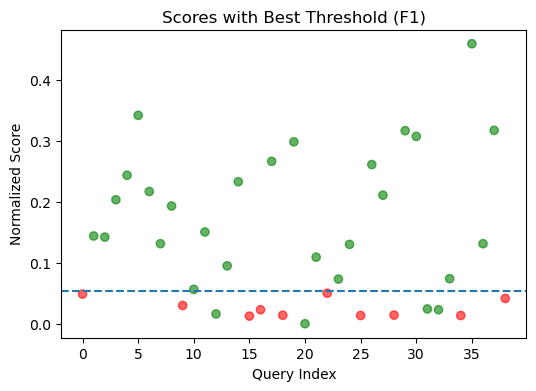

In [16]:
DB_FOLDER      = "../Data/BBDD/"
QUERY_FOLDER   = "../Data/Week4/qsd1_w4/"
GT_PATH        = "../Data/Week4/qsd1_w4/gt_corresps.pkl"

DESCRIPTOR         = "ORB"       # <- switch between "SIFT" and "ORB"
NFEATURES          = 2000        # both SIFT & ORB accept this parameter- For SIFT, typical is 1200; for ORB, typical is 2000
ROOTSIFT           = False       # ignored for ORB
ORB_FAST_THRESHOLD = 20
ORB_SCORE_TYPE     = "HARRIS"    # or "FAST"
SAVE_QUERY_DESC    = True        # whether to save/load query descriptors to/from pickle (keep true if no changes in the descriptor parameters)

LOWE_RATIO         = 0.76
RATE_THRESHOLD     = 0.053242 #####
MIN_SIZE_RATIO     = 0.
CROP_MIN_RATIO     = 0.20
BG_CROP_MIN_RATIO  = 0.10
SHOW_VIS           = False
INFO_PRINT         = False

# Cache file name reflects descriptor
DESC_DB_PATH   = f"results/descriptors_db_{DESCRIPTOR.lower()}.pkl"

os.makedirs("results", exist_ok=True)

# 1) Build matcher
matcher = create_matcher(DESCRIPTOR)

# 2) DB descriptors
db_descs, db_names = build_or_load_db_descriptors(
    DB_FOLDER,
    DESC_DB_PATH,
    descriptor_type=DESCRIPTOR,
    nfeatures=NFEATURES,
    rootsift=ROOTSIFT,
    orb_fast_threshold=ORB_FAST_THRESHOLD,
    orb_score_type=ORB_SCORE_TYPE,
    use_cache=True,
    progress=True,
)

# 3) Queries + GT
print("📥 Loading query images...")
q_names, q_imgs = load_images_from_folder(QUERY_FOLDER)
print("📥 Loading ground-truth correspondences...")
with open(GT_PATH, "rb") as f:
    gt_corresps = pickle.load(f)
print(f"→ {len(gt_corresps)} GT entries loaded")

# 4) Query descriptors
print(f"🧠 Computing {DESCRIPTOR} for queries...")
desc_query_orb = compute_query_descriptors(
    q_imgs,
    q_names,
    preprocess_image=preprocess_image,
    segment_multiple_paintings=segment_multiple_paintings,
    validate_split_fn=lambda is_split, imgs: validate_split(is_split, imgs, min_size_ratio=MIN_SIZE_RATIO),
    background_remover=background_remover,
    descriptor_type=DESCRIPTOR,
    nfeatures=NFEATURES,
    rootsift=ROOTSIFT,
    orb_fast_threshold=ORB_FAST_THRESHOLD,
    orb_score_type=ORB_SCORE_TYPE,
    crop_min_ratio_single=CROP_MIN_RATIO,
    bg_crop_min_ratio=BG_CROP_MIN_RATIO,
    show_img=SHOW_VIS,
    info=INFO_PRINT,
    save=SAVE_QUERY_DESC,
)

# 5) Ranking + mAP
predicted_obs, predicted_norm_scores_obs, predicted_scores_obs, predicted_num_features_obs = compute_matches(
    desc_query_orb,
    db_descs,
    gt_corresps,
    matcher=matcher,
    ratio=LOWE_RATIO,
    rate_threshold=RATE_THRESHOLD,
    # descriptor_type=DESCRIPTOR,
)

# Pick the best threshold from the produced rates + GT
best_th, side, metrics, y_pred = find_best_score_threshold(
    rates=predicted_norm_scores_obs,
    gt_corresps=gt_corresps,
    metric="f1",     # or "accuracy" / "youden"
    plot=True        # set False if you don’t want the visualization
)

print(f"Best threshold: score {side} {best_th:.6f} → predict KNOWN")
print(f"F1={metrics['f1']:.3f}  Precision={metrics['precision']:.3f}  "
      f"Recall={metrics['recall']:.3f}  Acc={metrics['accuracy']:.3f}")

map5_orb = mapk(gt_corresps, predicted_obs, k=5, skip_unknown=False)
map1_orb = mapk(gt_corresps, predicted_obs, k=1, skip_unknown=False)

print(f"✅ mAP@1 = {map1_orb:.4f}")
print(f"✅ mAP@5 = {map5_orb:.4f}")


Best threshold: score >= 34.500000 → predict KNOWN
F1=0.862  Precision=0.862  Recall=0.862  Acc=0.795


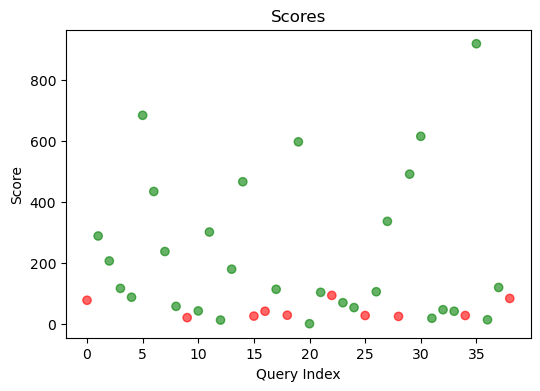

In [28]:
# Pick the best threshold from the produced rates + GT
best_th_old, side_old, metrics_old, y_pred_old = find_best_score_threshold(
    rates=predicted_scores_obs,
    gt_corresps=gt_corresps,
    metric="f1",     # or "accuracy" / "youden"
    plot=True,        # set False if you don’t want the visualization
    title_ylabel="Score",
    plot_threshold_line=False,
)

print(f"Best threshold: score {side_old} {best_th_old:.6f} → predict KNOWN")
print(f"F1={metrics_old['f1']:.3f}  Precision={metrics_old['precision']:.3f}  "
      f"Recall={metrics_old['recall']:.3f}  Acc={metrics_old['accuracy']:.3f}")

Best threshold: score >= 34.500000 → predict KNOWN
F1=0.862  Precision=0.862  Recall=0.862  Acc=0.795


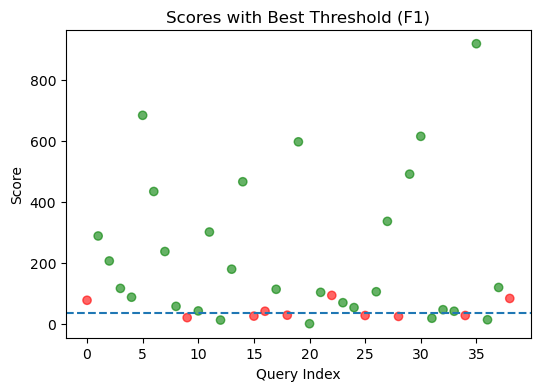

In [17]:
# Pick the best threshold from the produced rates + GT
best_th_old, side_old, metrics_old, y_pred_old = find_best_score_threshold(
    rates=predicted_scores_obs,
    gt_corresps=gt_corresps,
    metric="f1",     # or "accuracy" / "youden"
    plot=True,        # set False if you don’t want the visualization
    title_ylabel="Score"
)

print(f"Best threshold: score {side_old} {best_th_old:.6f} → predict KNOWN")
print(f"F1={metrics_old['f1']:.3f}  Precision={metrics_old['precision']:.3f}  "
      f"Recall={metrics_old['recall']:.3f}  Acc={metrics_old['accuracy']:.3f}")

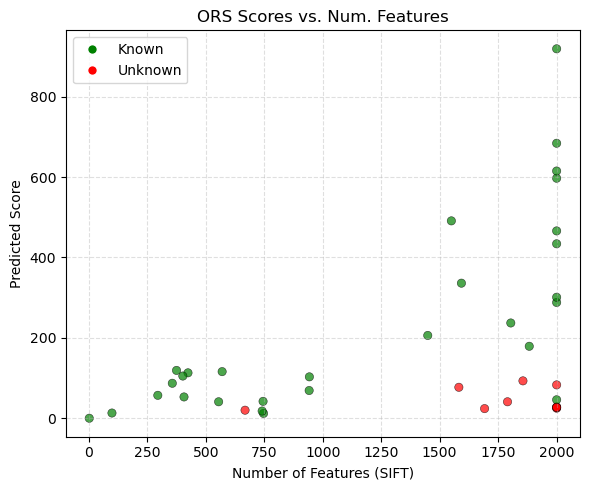

In [30]:
plot_score_vs_features(predicted_scores_obs, predicted_num_features_obs, gt_corresps, title="ORS Scores vs. Num. Features")

In [38]:
RATE_THRESHOLD = 0.053242
DESCRIPTOR = "ORB"
f1_orb = evaluate_unknown_threshold(gt_corresps, predicted_obs, 
                                threshold_name=f"rate{RATE_THRESHOLD:.3f}", 
                                descriptor=DESCRIPTOR, normalize=True)

Threshold rate0.053 → Precision=1.000, Recall=0.862, F1=0.926


Min score for correct matches: 0.023
Max score for incorrect matches: 0.056375838926174496


Rate thereshold = 0.01 gives:
✅ mAP@1 = 0.6410
✅ mAP@5 = 0.6560
Threshold rate0.010 → Precision=0.737, Recall=0.966, F1=0.836

Rate thereshold = 0.02 gives:
✅ mAP@1 = 0.7692
✅ mAP@5 = 0.7756
Threshold rate0.020 → Precision=0.844, Recall=0.931, F1=0.885

Rate thereshold = 0.03 gives:
✅ mAP@1 = 0.7949
✅ mAP@5 = 0.7949
Threshold rate0.030 → Precision=0.893, Recall=0.862, F1=0.877

Rate thereshold = 0.04 gives:
✅ mAP@1 = 0.7949
✅ mAP@5 = 0.7949
Threshold rate0.040 → Precision=0.893, Recall=0.862, F1=0.877

Rate thereshold = 0.05 gives:
✅ mAP@1 = 0.8462
✅ mAP@5 = 0.8462
Threshold rate0.050 → Precision=0.962, Recall=0.862, F1=0.909

Rate thereshold = 0.055 gives:
✅ mAP@1 = 0.8718
✅ mAP@5 = 0.8718
Threshold rate0.055 → Precision=1.000, Recall=0.862, F1=0.926

Rate thereshold = 0.06 gives:
✅ mAP@1 = 0.8718
✅ mAP@5 = 0.8718
Threshold rate0.060 → Precision=1.000, Recall=0.828, F1=0.906

Rate thereshold = 0.07 gives:
✅ mAP@1 = 0.8718
✅ mAP@5 = 0.8718
Threshold rate0.070 → Precision=1.000, Recall=0.828, F1=0.906

Rate thereshold = 0.08 gives:
✅ mAP@1 = 0.8205
✅ mAP@5 = 0.8205
Threshold rate0.080 → Precision=1.000, Recall=0.759, F1=0.863

Rate thereshold = 0.09 gives:
✅ mAP@1 = 0.8205
✅ mAP@5 = 0.8205
Threshold rate0.090 → Precision=1.000, Recall=0.759, F1=0.863

Rate thereshold = 0.1 gives:
✅ mAP@1 = 0.7949
✅ mAP@5 = 0.7949
Threshold rate0.100 → Precision=1.000, Recall=0.724, F1=0.840

## CSIFT

✅ Loading DB descriptors from results/descriptors_db_csift_opponent.pkl
📥 Loading query images...
📥 Loading ground-truth correspondences...
→ 30 GT entries loaded
🧠 Computing CSIFT for queries...
✅ Loading query descriptors from results/query_descriptors_CSIFT.pkl
🔍 Computing matches...


Processing queries: 100%|██████████| 30/30 [16:10<00:00, 32.36s/it]


Min score for correct matches: 0.04271356783919598
Max score for incorrect matches: 0.06933333333333333
Best threshold: score >= 0.042357 → predict KNOWN
F1=0.966  Precision=0.966  Recall=0.966  Acc=0.949
✅ mAP@1 = 0.9231
✅ mAP@5 = 0.9231


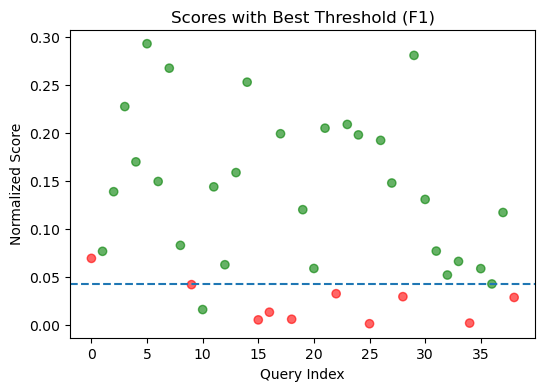

In [19]:
DB_FOLDER      = "../Data/BBDD/"
QUERY_FOLDER   = "../Data/Week4/qsd1_w4/"
GT_PATH        = "../Data/Week4/qsd1_w4/gt_corresps.pkl"

DESCRIPTOR         = "CSIFT"     # <- "SIFT" | "ORB" | "CSIFT"
COLOR_SPACE        = "OPPONENT"  # <- for CSIFT: "OPPONENT" | "RGB" | "HSV"

NFEATURES          = 1500        # works for SIFT/CSIFT; ORB uses same param name
ROOTSIFT           = True        # applies to SIFT/CSIFT only
ORB_FAST_THRESHOLD = 20
ORB_SCORE_TYPE     = "HARRIS"    # or "FAST"
SAVE_QUERY_DESC    = True        # whether to save/load query descriptors to/from pickle (keep true if no changes in the descriptor parameters)

LOWE_RATIO         = 0.76
RATE_THRESHOLD     = 0.042023 #####
MIN_SIZE_RATIO     = 0.20
CROP_MIN_RATIO     = 0.20
BG_CROP_MIN_RATIO  = 0.10
SHOW_VIS           = False
INFO_PRINT         = False


DESC_DB_PATH   = f"results/descriptors_db_{DESCRIPTOR.lower()}_{COLOR_SPACE.lower() if DESCRIPTOR.upper()=='CSIFT' else ''}.pkl".replace("__","_")

os.makedirs("results", exist_ok=True)

# 1) Matcher
matcher = create_matcher(DESCRIPTOR)

# 2) DB descriptors
db_descs, db_names = build_or_load_db_descriptors(
    DB_FOLDER,
    DESC_DB_PATH,
    descriptor_type=DESCRIPTOR,
    nfeatures=NFEATURES,
    rootsift=ROOTSIFT,
    color_space=COLOR_SPACE,
    orb_fast_threshold=ORB_FAST_THRESHOLD,
    orb_score_type=ORB_SCORE_TYPE,
    use_cache=True,
    progress=True,
)

# 3) Queries + GT
print("📥 Loading query images...")
q_names, q_imgs = load_images_from_folder(QUERY_FOLDER)
print("📥 Loading ground-truth correspondences...")
with open(GT_PATH, "rb") as f:
    gt_corresps = pickle.load(f)
print(f"→ {len(gt_corresps)} GT entries loaded")

# 4) Query descriptors
print(f"🧠 Computing {DESCRIPTOR} for queries...")
desc_query_csift = compute_query_descriptors(
    q_imgs,
    q_names,
    preprocess_image=preprocess_image,
    segment_multiple_paintings=segment_multiple_paintings,
    validate_split_fn=lambda is_split, imgs: validate_split(is_split, imgs, min_size_ratio=MIN_SIZE_RATIO),
    background_remover=background_remover,
    descriptor_type=DESCRIPTOR,
    nfeatures=NFEATURES,
    rootsift=ROOTSIFT,
    color_space=COLOR_SPACE,
    orb_fast_threshold=ORB_FAST_THRESHOLD,
    orb_score_type=ORB_SCORE_TYPE,
    crop_min_ratio_single=CROP_MIN_RATIO,
    bg_crop_min_ratio=BG_CROP_MIN_RATIO,
    show_img=SHOW_VIS,
    info=INFO_PRINT,
    save=SAVE_QUERY_DESC,
)

# 5) Ranking + mAP
print("🔍 Computing matches...")
predicted_csift, predicted_norm_scores_csift, predicted_scores_csift, predicted_num_features_csift = compute_matches(
    desc_query_csift,
    db_descs,
    gt_corresps,
    matcher=matcher,
    ratio=LOWE_RATIO,
    rate_threshold=RATE_THRESHOLD,
    # descriptor_type=DESCRIPTOR,
)

# Pick the best threshold from the produced rates + GT
best_th, side, metrics, y_pred = find_best_score_threshold(
    rates=predicted_norm_scores_csift,
    gt_corresps=gt_corresps,
    metric="f1",     # or "accuracy" / "youden"
    plot=True        # set False if you don’t want the visualization
)

print(f"Best threshold: score {side} {best_th:.6f} → predict KNOWN")
print(f"F1={metrics['f1']:.3f}  Precision={metrics['precision']:.3f}  "
      f"Recall={metrics['recall']:.3f}  Acc={metrics['accuracy']:.3f}")

map5_csift = mapk(gt_corresps, predicted_csift, k=5, skip_unknown=False)
map1_csift = mapk(gt_corresps, predicted_csift, k=1, skip_unknown=False)

print(f"✅ mAP@1 = {map1_csift:.4f}")
print(f"✅ mAP@5 = {map5_csift:.4f}")

Best threshold: score >= 12.000000 → predict KNOWN
F1=0.871  Precision=0.818  Recall=0.931  Acc=0.795


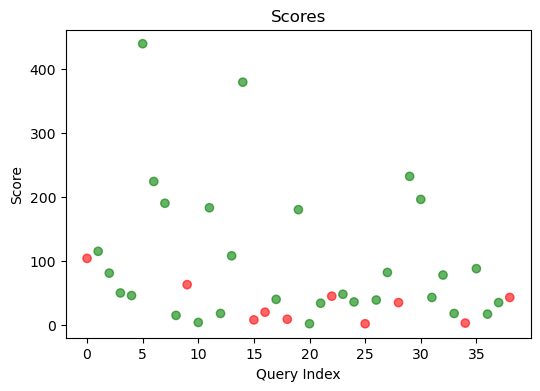

In [25]:
# Pick the best threshold from the produced rates + GT
best_th_old_csift, side_old_csift, metrics_old_csift, y_pred_old_csift = find_best_score_threshold(
    rates=predicted_scores_csift,
    gt_corresps=gt_corresps,
    metric="f1",     # or "accuracy" / "youden"
    plot=True,        # set False if you don’t want the visualization
    title_ylabel="Score",
    plot_threshold_line=False,
)

print(f"Best threshold: score {side_old_csift} {best_th_old_csift:.6f} → predict KNOWN")
print(f"F1={metrics_old_csift['f1']:.3f}  Precision={metrics_old_csift['precision']:.3f}  "
      f"Recall={metrics_old_csift['recall']:.3f}  Acc={metrics_old_csift['accuracy']:.3f}")

Best threshold: score >= 12.000000 → predict KNOWN
F1=0.871  Precision=0.818  Recall=0.931  Acc=0.795


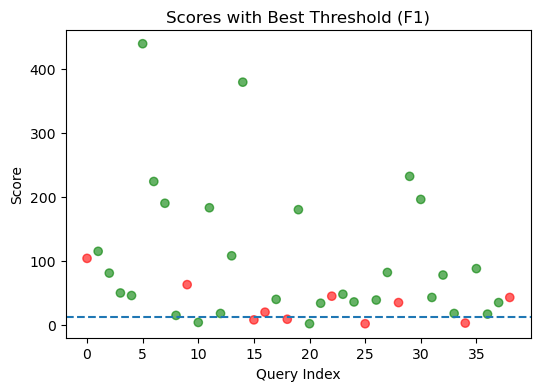

In [29]:
# Pick the best threshold from the produced rates + GT
best_th_old_csift, side_old_csift, metrics_old_csift, y_pred_old_csift = find_best_score_threshold(
    rates=predicted_scores_csift,
    gt_corresps=gt_corresps,
    metric="f1",     # or "accuracy" / "youden"
    plot=True,        # set False if you don’t want the visualization
    title_ylabel="Score"
)

print(f"Best threshold: score {side_old_csift} {best_th_old_csift:.6f} → predict KNOWN")
print(f"F1={metrics_old_csift['f1']:.3f}  Precision={metrics_old_csift['precision']:.3f}  "
      f"Recall={metrics_old_csift['recall']:.3f}  Acc={metrics_old_csift['accuracy']:.3f}")

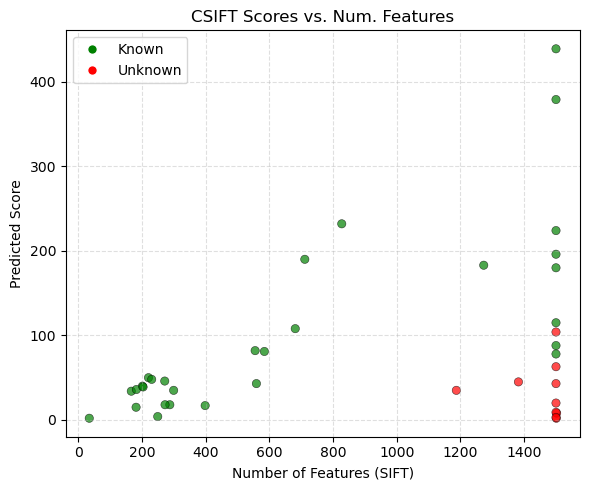

In [21]:
plot_score_vs_features(predicted_scores_csift, predicted_num_features_csift, gt_corresps, title="CSIFT Scores vs. Num. Features")

In [37]:
RATE_THRESHOLD = 0.042023
DESCRIPTOR = "CSIFT"
f1_csift = evaluate_unknown_threshold(gt_corresps, predicted_csift, 
                                threshold_name=f"rate{RATE_THRESHOLD:.3f}", 
                                descriptor=DESCRIPTOR)

Threshold rate0.042 → Precision=0.966, Recall=0.966, F1=0.966


Min score for correct matches: 0.050666666666666665
Max score for incorrect matches: 0.06866666666666667

Rate threshold = 0.01 gives:
✅ mAP@1 = 0.7949
✅ mAP@5 = 0.8034
Threshold rate0.010 → Precision=0.829, Recall=1.000, F1=0.906

Rate threshold = 0.02 gives:
✅ mAP@1 = 0.8205
✅ mAP@5 = 0.8205
Threshold rate0.020 → Precision=0.848, Recall=0.966, F1=0.903

Rate threshold = 0.03 gives:
✅ mAP@1 = 0.8718
✅ mAP@5 = 0.8718
Threshold rate0.030 → Precision=0.903, Recall=0.966, F1=0.933

Rate threshold = 0.04 gives:
✅ mAP@1 = 0.8974
✅ mAP@5 = 0.8974
Threshold rate0.040 → Precision=0.933, Recall=0.966, F1=0.949

Rate thereshold = 0.045 gives:
✅ mAP@1 = 0.8974
✅ mAP@5 = 0.9060
Threshold rate0.045 → Precision=0.966, Recall=0.966, F1=0.966

Rate thereshold = 0.05 gives:
✅ mAP@1 = 0.8974
✅ mAP@5 = 0.8974
Threshold rate0.050 → Precision=0.964, Recall=0.931, F1=0.947

Rate threshold = 0.06 gives:
✅ mAP@1 = 0.8462
✅ mAP@5 = 0.8462
Threshold rate0.060 → Precision=0.960, Recall=0.828, F1=0.889

Rate threshold = 0.07 gives:
✅ mAP@1 = 0.8462
✅ mAP@5 = 0.8462
Threshold rate0.070 → Precision=1.000, Recall=0.793, F1=0.885

In [53]:
len(predicted_csift[2])

2

In [ ]:
# for all the predicted in csift, print the query index, top 5 predicted image, norm score and gt and number of features
for q_idx, (preds, scores, gt_sub, num_feats) in enumerate(zip(predicted_csift, predicted_norm_scores_csift, gt_corresps, predicted_num_features_csift)):
    if len(preds) >= 5:
        print(f"Query {q_idx}, scores: {scores}, GT: {gt_sub}, Num Features: {num_feats}")
        for rank in range(5):
            print(f"  Rank {rank+1}: Image {preds[rank]}")
    elif len(preds) == 1:
        print(f"Query {q_idx} has only 1 prediction. Norm Score {scores[0]:.4f}, GT {gt_sub}, Num Features: {num_feats}")
    else: # len(preds) == 2:
        print(f"Query {q_idx} has only 2 predictions.")
        print(f"  Left: Scores {scores[0]:.4f}, GT {gt_sub[0]}, Num Features: {num_feats}")
        if len(preds[0]) >= 5:
            for rank in range(5):
                print(f"    Rank {rank+1}: Image {preds[0][rank]}")
        if len(preds) == 1:
            print(f"    Unknown prediction")
        print(f"  Right: Scores {scores[1]:.4f}, GT {gt_sub[1]}, Num Features: {num_feats}")
        if len(preds[1]) >= 5:
            for rank in range(5):
                print(f"    Rank {rank+1}: Image {preds[1][rank]}")
        if len(preds) == 1:
            print(f"    Unknown prediction")

Query 0, scores: [0.06933333333333333], GT: [-1], Num Features: [1500]
  Rank 1: Image 137
  Rank 2: Image 209
  Rank 3: Image 136
  Rank 4: Image 106
  Rank 5: Image 248
Query 1, scores: [0.07666666666666666], GT: [150], Num Features: [1500]
  Rank 1: Image 150
  Rank 2: Image 268
  Rank 3: Image 95
  Rank 4: Image 178
  Rank 5: Image 233
Query 2 has only 2 predictions.
  Left: Scores 0.1387, GT 48, Num Features: [584, 220]
    Rank 1: Image 48
    Rank 2: Image 8
    Rank 3: Image 11
    Rank 4: Image 52
    Rank 5: Image 150
  Right: Scores 0.2273, GT 251, Num Features: [584, 220]
    Rank 1: Image 251
    Rank 2: Image 226
    Rank 3: Image 54
    Rank 4: Image 44
    Rank 5: Image 134
Query 3, scores: [0.16974169741697417], GT: [32], Num Features: [271]
  Rank 1: Image 32
  Rank 2: Image 189
  Rank 3: Image 88
  Rank 4: Image 8
  Rank 5: Image 109
Query 4, scores: [0.2926666666666667], GT: [161], Num Features: [1500]
  Rank 1: Image 161
  Rank 2: Image 44
  Rank 3: Image 88
  Rank